In [1]:
import torch
import torch.nn as nn
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader
import gpytorch
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(119, 360)
        self.fc2 = nn.Linear(360, 180)
        self.fc3 = nn.Linear(180, 100)
        self.fc4 = nn.Linear(100, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x
model = NN()

In [3]:
def train(train_loader, device, model, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)
    return average_loss

def validate(validation_loader, device, model, criterion):
    model.eval()
    running_loss = 0.0
    validation_outputs = []
    validation_truth = []

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            validation_outputs.append(outputs.detach().numpy())
            validation_truth.append(labels.detach().numpy())

    average_loss = running_loss / len(validation_loader)
    validation_outputs = np.concatenate(validation_outputs)
    validation_truth = np.concatenate(validation_truth)

    return average_loss, validation_outputs, validation_truth


def test(test_loader, device, model, criterion):
    model.eval()
    running_loss = 0.0
    test_outputs = []
    test_truth = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            test_outputs.append(outputs.detach().numpy())
            test_truth.append(targets.detach().numpy())

    average_loss = running_loss / len(test_loader)
    test_outputs = np.concatenate(test_outputs)
    test_truth = np.concatenate(test_truth)

    return average_loss, test_outputs, test_truth

In [4]:
from torchvision import datasets, transforms
import copy


EPOCHS = 10
learning_rate = 0.1

validation_losses = []

# Example transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Example random dataset
num_samples = 10000
num_features = 119

features_array = np.random.rand(num_samples, num_features).astype(np.float32)
labels_array = np.random.randint(0, 2, size=num_samples).astype(np.float32)

features_list = torch.tensor(features_array)
labels_list = torch.tensor(labels_array)


class InterruptExecution(Exception):
    pass

data_list = list(zip(features_list, labels_list))


sampling_size = 6

best_vals =[]
best_models = []
best_tests = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_test_split_index = int(0.9 * len(data_list))

train_val_data = data_list[:train_test_split_index]

test_data = data_list[train_test_split_index:]
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

data_len = len(train_val_data)

num_batches = data_len / sampling_size

num_batches = 5 # TODO: Remove this line

indices = np.arange(data_len)
for i in range(num_batches):
    best_val_loss = np.inf

    start_index = i * sampling_size

    val_indices = indices[start_index:start_index + sampling_size]

    train_indices = np.setdiff1d(indices, val_indices)

    train_data = [train_val_data[j] for j in train_indices]
    val_data = [train_val_data[j] for j in val_indices]

    print(f"Batch {i+1}/{num_batches}, Train Size: {len(train_data)}, Validation Size: {len(val_data)}")

    train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
    validation_loader = DataLoader(val_data, batch_size=16, shuffle=False)

    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                        factor=0.8, patience=5,
                                                        min_lr=0.0000001)
    criterion = nn.L1Loss()
    best_validation_loss = float('inf')

    for epoch in range(1, EPOCHS+1):

        model.train()



        loss = train(train_loader, device, model, optimizer, criterion)
        scheduler.step(loss)

        validation_loss, validation_output, validation_truth_temp = validate(validation_loader, device, model, criterion)
        # print(f"Epoch {epoch+1}, Train Loss: {loss:.4f}, Validation Loss: {validation_loss:.4f}")
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            best_model_state = copy.deepcopy(model.state_dict())
            best_model = model
            best_val_loss = validation_loss
            print(f"Best Validation Loss: {best_val_loss:.4f}")

    # Store the best validation loss for the current batch
    validation_losses.append(best_val_loss)
    
model.load_state_dict(best_model_state)
test_loss, test_outputs, test_truth = test(test_loader, device, model, criterion)
print(f"Test Loss: {test_loss:.4f}")


Batch 1/5, Train Size: 8994, Validation Size: 6


/opt/miniconda3/envs/aiDev/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/opt/miniconda3/envs/aiDev/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/opt/miniconda3/envs/aiDev/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

Best Validation Loss: 0.4294
Best Validation Loss: 0.3690
Best Validation Loss: 0.3414
Batch 2/5, Train Size: 8994, Validation Size: 6
Best Validation Loss: 0.5000
Batch 3/5, Train Size: 8994, Validation Size: 6
Best Validation Loss: 0.4774
Best Validation Loss: 0.4277
Best Validation Loss: 0.3556
Batch 4/5, Train Size: 8994, Validation Size: 6
Best Validation Loss: 0.5000
Batch 5/5, Train Size: 8994, Validation Size: 6
Best Validation Loss: 0.3598


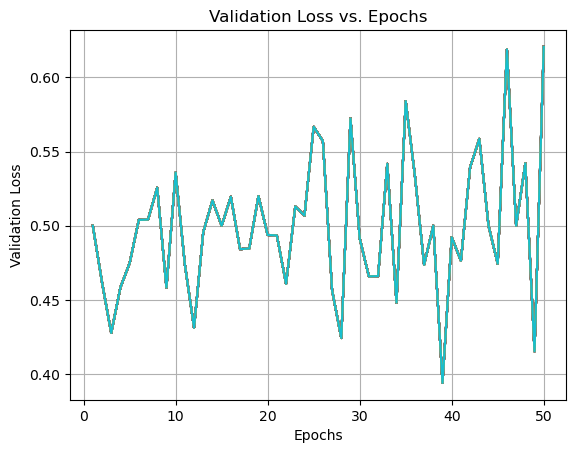

In [ ]:
""" # Plot validation loss vs. batches
batches = np.arange(1, 834 + 1)
plt.figure()
plt.plot(batches, validation_losses, '-o')
plt.xlabel('Batches')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Batches')
plt.grid(True)
plt.show() """

# Plot validation loss vs. epochs for each batch
plt.figure()
for i, val_losses in enumerate(validation_losses_per_epoch):
    epochs = np.arange(1, EPOCHS * 5 + 1) 
    plt.plot(epochs, val_losses, label=f'Batch {i+1}')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Epochs')
#plt.legend()
plt.grid(True)
plt.show()

In [ ]:
X = np.random.rand(1000, 119)  # Example: 1000 samples, 10 features
y = np.random.rand(1000)      # Example: 1000 target values


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

evals = [(dtrain, 'train'), (dval, 'eval')]

num_boost_round = 100
early_stopping_rounds = 10
model = xgb.train(params, dtrain, num_boost_round, evals, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

y_pred = model.predict(dtest)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Test RMSE: {test_rmse:.4f}')

[0]	train-rmse:0.27419	eval-rmse:0.26459
[1]	train-rmse:0.26887	eval-rmse:0.26398
[2]	train-rmse:0.26116	eval-rmse:0.26368
[3]	train-rmse:0.25369	eval-rmse:0.26536
[4]	train-rmse:0.24690	eval-rmse:0.26497
[5]	train-rmse:0.24136	eval-rmse:0.26537
[6]	train-rmse:0.23247	eval-rmse:0.27076
[7]	train-rmse:0.22596	eval-rmse:0.27021
[8]	train-rmse:0.21879	eval-rmse:0.27227
[9]	train-rmse:0.21218	eval-rmse:0.27145
[10]	train-rmse:0.20815	eval-rmse:0.27076
[11]	train-rmse:0.20205	eval-rmse:0.27144
[12]	train-rmse:0.19546	eval-rmse:0.27162


/opt/miniconda3/envs/aiDev/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Test RMSE: 0.2892


/opt/miniconda3/envs/aiDev/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
